In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely import wkt
from matplotlib import pyplot as plt
import descartes
import seaborn as sns
import datetime as dt
import geoplot as geoplot
from sklearn.preprocessing import MultiLabelBinarizer

In [2]:
#read in the cleaned data

airbnb = pd.read_csv('../data/cleaned_for_eda/airbnb.csv')
airbnb.head()

,the_geom,OBJECTID,geoid,Median Sales Price,PercentShortTermRentals,geometry,index_right,id,name,description,...,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,reviews_per_month,days_active,lowest_estimate/month,middle_estimate/month,Restaurant_Count,neighborhood_restaurants
0,MULTIPOLYGON (((-90.08430161674 29.96889441780...,336,220710044011,134250.0,4.626335,MULTIPOLYGON (((-90.08430161674001 29.96889441...,3012,24853908,Stayloom’s Radiant & Renovated Home | near FQ,Our home is professionally cleaned and sanitiz...,...,9.0,10.0,True,1,2.06,954.0,296.6400,1483.200,1.0,7.0
1,MULTIPOLYGON (((-90.08430161674 29.96889441780...,336,220710044011,134250.0,4.626335,MULTIPOLYGON (((-90.08430161674001 29.96889441...,3780,31221667,Sonder | Tremé Flats | Warm 3BR + Backyard,Whether you are just getting away for the week...,...,9.0,10.0,True,63,1.13,670.0,214.7000,536.750,1.0,7.0
2,MULTIPOLYGON (((-90.08430161674 29.96889441780...,336,220710044011,134250.0,4.626335,MULTIPOLYGON (((-90.08430161674001 29.96889441...,2801,24023311,"Cute, Clean, Convenient Treme/Mid-City Location!",Traditional shotgun double in fantastic Mid-Ci...,...,10.0,10.0,True,1,1.96,996.0,276.0856,690.214,1.0,7.0
3,MULTIPOLYGON (((-90.08430161674 29.96889441780...,336,220710044011,134250.0,4.626335,MULTIPOLYGON (((-90.08430161674001 29.96889441...,3316,27779648,Sonder | Tremé Flats | Warm 3BR,Whether you are just getting away for the week...,...,9.0,9.0,True,33,1.37,834.0,246.6000,616.500,1.0,7.0
4,MULTIPOLYGON (((-90.08430161674 29.96889441780...,336,220710044011,134250.0,4.626335,MULTIPOLYGON (((-90.08430161674001 29.96889441...,2787,23935301,"HISTORIC TREME, StreetCar, & Willie Mae's!",Beautiful Newly Renovated Treme Historical Sho...,...,10.0,9.0,True,1,1.65,946.0,440.5500,734.250,1.0,7.0


In [3]:
ints = []
floats = []
for column, dtype in airbnb.dtypes.iteritems():
    if dtype == 'int64':
        ints.append(column)
    if dtype == 'float64':
        floats.append(column)

In [4]:
pd.options.display.max_rows = len(airbnb.columns)

In [5]:
airbnb.shape

(2241, 54)

The histograms below compare distributions of potential target variables.

Text(0.5, 0, 'Middle Estimate/Month')

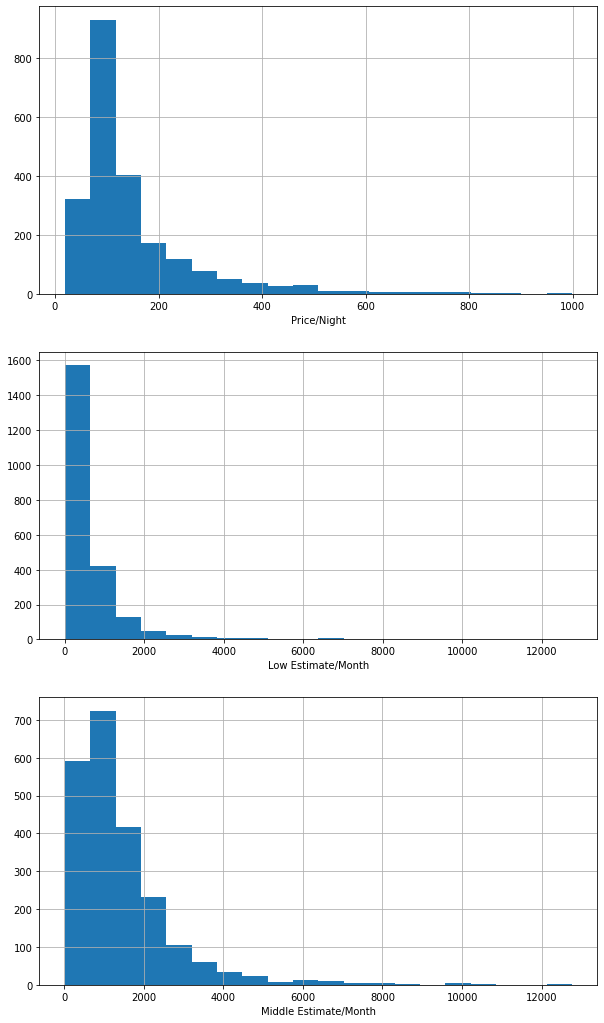

In [6]:
plt.figure(figsize = (10,18))
plt.subplot(3,1,1)
airbnb['price'].hist(bins = 20)
plt.xlabel("Price/Night")
plt.subplot(3,1,2)
airbnb['lowest_estimate/month'].hist(bins = 20)
plt.xlabel("Low Estimate/Month")
plt.subplot(3,1,3)
airbnb['middle_estimate/month'].hist(bins = 20)
plt.xlabel('Middle Estimate/Month')

<AxesSubplot:xlabel='room_type', ylabel='middle_estimate/month'>

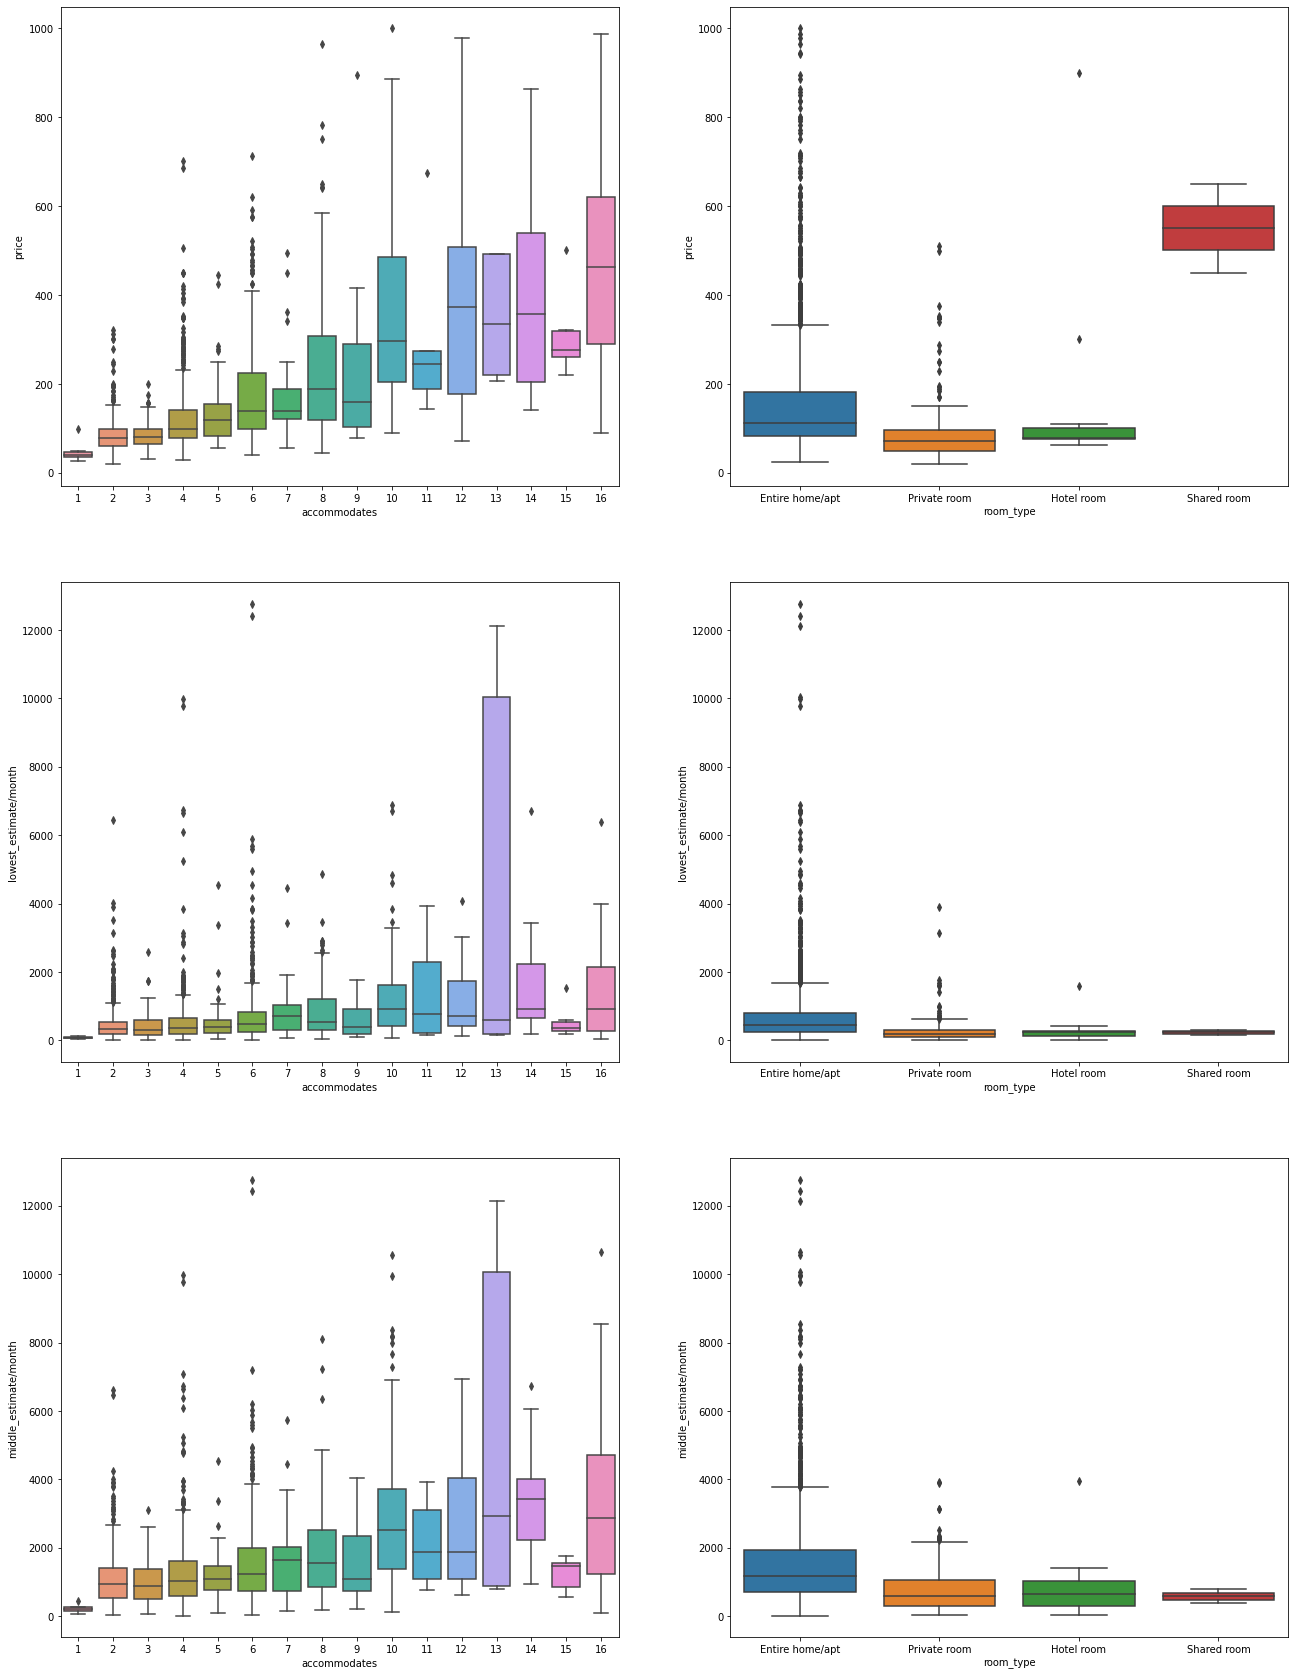

In [7]:
plt.figure(figsize = (22, 30))
#plt.subplots(2,1)
plt.subplot(3,2,1)
sns.boxplot(y='price', x = 'accommodates', data = airbnb)
#axes[0].set_title('Review Score')
plt.subplot(3,2,2)
sns.boxplot(y='price', x = 'room_type', data = airbnb)
#axes[1].set_title('Accomodates')
plt.subplot(3,2,3)
sns.boxplot(y='lowest_estimate/month', x = 'accommodates', data = airbnb)
plt.subplot(3,2,4)
sns.boxplot(y='lowest_estimate/month', x = 'room_type', data = airbnb)
plt.subplot(3,2,5)
sns.boxplot(y='middle_estimate/month', x = 'accommodates', data = airbnb)
plt.subplot(3,2,6)
sns.boxplot(y='middle_estimate/month', x = 'room_type', data = airbnb)


There seems to be a relationship with price and number of people the listing accommodates. The mean price of listings rises with more accommodation, but the variance seems to rise as well. 
It seems suspicious to me that the price for shared room could be so expensive.  So the next lines of code explore this further. 
This first line filters out the expensive shared room. Looking this up on airbnb shows that it is actually a large hotel room that accomades multiple guests of the same party.
Next, I find the lowest price shared room and it links me to the same hotel room on airbnb. 
Further exploration shows there are only a few shared rooms. Most belong to this hotel and are not relavant to my potential model so the are removed from the data set.

In [8]:
#This listing on airbnb seems to be a hotel room for multiple people.
print(airbnb[['name','price','room_type','property_type']][(airbnb['room_type']=='Shared room') & (airbnb["price"]>400)])

                                                   name  price    room_type  \
1077  JAZZ QUARTERS-THE MARSALIS-3 BLOCKS TO BOURBON...  650.0  Shared room   
1080  JAZZ QUARTERS-ARMSTRONG SUITE-3 BLOCKS TO BOURBON  450.0  Shared room   

               property_type  
1077  Shared room in cottage  
1080  Shared room in cottage  


In [9]:
np.min(airbnb[['name','price']][airbnb['room_type']=='Shared room'])

name     JAZZ QUARTERS-ARMSTRONG SUITE-3 BLOCKS TO BOURBON
price                                                  450
dtype: object

In [10]:
#I'm not really sure what 'shared room' means and there are only six of them so I'm deleting them
print(len(airbnb[airbnb["room_type"]=='Shared room']))
airbnb = airbnb[airbnb['room_type']!='Shared room']

2



This makes me curious about the other room types. So the next lines of code show there are only 37 hotel rooms and I'm only interested in how much a homeowner can make earn with an airbnb and since there are so few hotel rooms, I'm not worried about weakening the data by deleting them.


In [11]:
print("There are " + str(len(airbnb[airbnb["room_type"]=='Entire home/apt'])) +" entire homes listed")
print("There are " +str(len(airbnb[airbnb['room_type']=='Hotel room'])) +" hotel rooms listed")
print("There are " + str(len(airbnb[airbnb['room_type']=='Private room'])) +" private rooms listed")
airbnb = airbnb[airbnb['room_type']!='Hotel room']
print("There are now " +str(len(airbnb[airbnb['room_type']=='Hotel room'])) +" hotel rooms listed")

There are 1969 entire homes listed
There are 17 hotel rooms listed
There are 253 private rooms listed
There are now 0 hotel rooms listed


There are only 435 private rooms listed and the boxplots above show a clear distinction in price between private roooms and entire homes. The boxplot and summary statistics below show more accurate comparison of private rooms and entire homes by only using entire homes that accommodate 1 person. 

<AxesSubplot:xlabel='room_type', ylabel='price'>

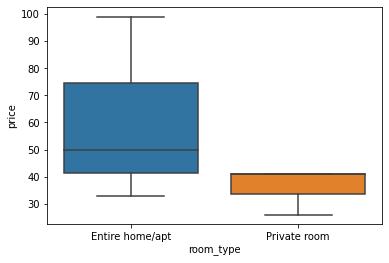

In [12]:
sns.boxplot(data = airbnb, x = airbnb.room_type[airbnb['accommodates']==1], y = 'price' )

In [13]:
print(airbnb['price'][airbnb['accommodates']==1].groupby(airbnb.room_type).describe())

                 count       mean        std   min   25%   50%   75%   max
room_type                                                                 
Entire home/apt    3.0  60.666667  34.268547  33.0  41.5  50.0  74.5  99.0
Private room       3.0  36.000000   8.660254  26.0  33.5  41.0  41.0  41.0




There are actually only 10 private rooms that only accommodate 1 person.  So below I make a new potential target variable: price per night per person.

In [14]:
print(airbnb.accommodates[airbnb['room_type']=='Private room'].unique())

[ 4  3  2  5  8 12  1 16  6  7]


<AxesSubplot:xlabel='room_type', ylabel='price_person'>

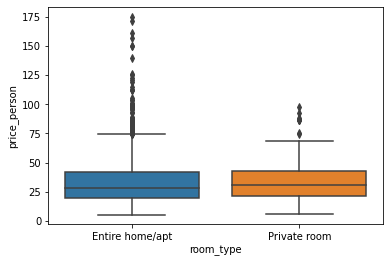

In [15]:
airbnb['price_person']= airbnb.price/airbnb.accommodates
sns.boxplot(data = airbnb, x = airbnb.room_type, y = 'price_person' )

In [16]:
print(airbnb['price_person'].groupby(airbnb.room_type).describe())

                  count       mean        std     min    25%   50%        75%  \
room_type                                                                       
Entire home/apt  1969.0  33.528320  19.879080  5.5000  19.75  28.5  41.666667   
Private room      253.0  34.217389  17.266553  5.5625  21.50  31.0  42.500000   

                   max  
room_type               
Entire home/apt  175.0  
Private room      97.5  


The distribution of price perperson for room types is not different enough to treat as separate datasets.  

Text(0.5, 0, 'Price/Night/Person')

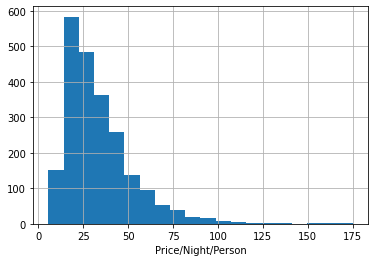

In [17]:
#this histogram shows a slightly more normal distribution than the other target variables did.
airbnb['price_person'].hist(bins = 20)
plt.xlabel('Price/Night/Person')

In [18]:
airbnb = airbnb.drop(columns = "room_type")

The next lines take any column where there is only one value and removes the column. 

In [19]:
print(airbnb.shape)
for col in airbnb.columns:
    if len(airbnb[col].unique()) == 1:
        airbnb.drop(col,inplace=True,axis=1)
print(airbnb.shape)

(2222, 54)
(2222, 54)


In [20]:
price_corr = airbnb.corr()
price_corr = price_corr['price'].dropna().sort_values().reset_index()
price_corr = price_corr.iloc[price_corr['price'].abs().argsort()]
print(price_corr.tail(20))

                             index     price
27                 availability_90  0.059495
28                 availability_60  0.063726
29                 availability_30  0.064683
30       review_scores_cleanliness  0.067756
4                 Restaurant_Count -0.082868
31            review_scores_rating  0.102338
3   calculated_host_listings_count -0.103784
32              Median Sales Price  0.107264
2           number_of_reviews_l30d -0.159322
1                number_of_reviews -0.196411
33                availability_365  0.228507
0                reviews_per_month -0.291290
34           lowest_estimate/month  0.420298
35           middle_estimate/month  0.547569
36                    price_person  0.572736
37                    accommodates  0.606130
38                            beds  0.613916
39                        bedrooms  0.653216
40                  bathrooms_text  0.664446
41                           price  1.000000


In [21]:
midestimate_corr = airbnb.corr()
midestimate_corr = midestimate_corr['middle_estimate/month'].dropna().sort_values().reset_index()
midestimate_corr = midestimate_corr.iloc[midestimate_corr['middle_estimate/month'].abs().argsort()]
print(midestimate_corr.tail(20))

                             index  middle_estimate/month
23           review_scores_checkin               0.094705
24          number_of_reviews_l30d               0.112001
25     review_scores_communication               0.113741
26            host_acceptance_rate               0.121877
27          review_scores_accuracy               0.131695
28       review_scores_cleanliness               0.135255
29               host_is_superhost               0.138358
0   calculated_host_listings_count              -0.143507
30            review_scores_rating               0.148045
31                  minimum_nights               0.168954
32               number_of_reviews               0.236165
33                    price_person               0.293184
34               reviews_per_month               0.334182
35                            beds               0.368093
36                    accommodates               0.371301
37                  bathrooms_text               0.379058
38            

In [22]:
lowestimate_corr = airbnb.corr()
lowestimate_corr = lowestimate_corr['lowest_estimate/month'].dropna().sort_values().reset_index()
lowestimate_corr = lowestimate_corr.iloc[lowestimate_corr['lowest_estimate/month'].abs().argsort()]
print(lowestimate_corr.tail(20))

                             index  lowest_estimate/month
25           review_scores_checkin               0.088129
26               host_is_superhost               0.088351
27               number_of_reviews               0.095626
2                      index_right              -0.097158
1                               id              -0.098596
28     review_scores_communication               0.100647
29                     days_active               0.101206
30          review_scores_accuracy               0.107011
31       review_scores_cleanliness               0.122710
32            review_scores_rating               0.124468
0   calculated_host_listings_count              -0.134018
33                            beds               0.252589
34                    accommodates               0.257743
35                  bathrooms_text               0.263516
36                    price_person               0.274292
37                        bedrooms               0.303007
38            

# Neighborhoods 

The next set section is a set of maps that will help visualize any spacial relationships in the data. 

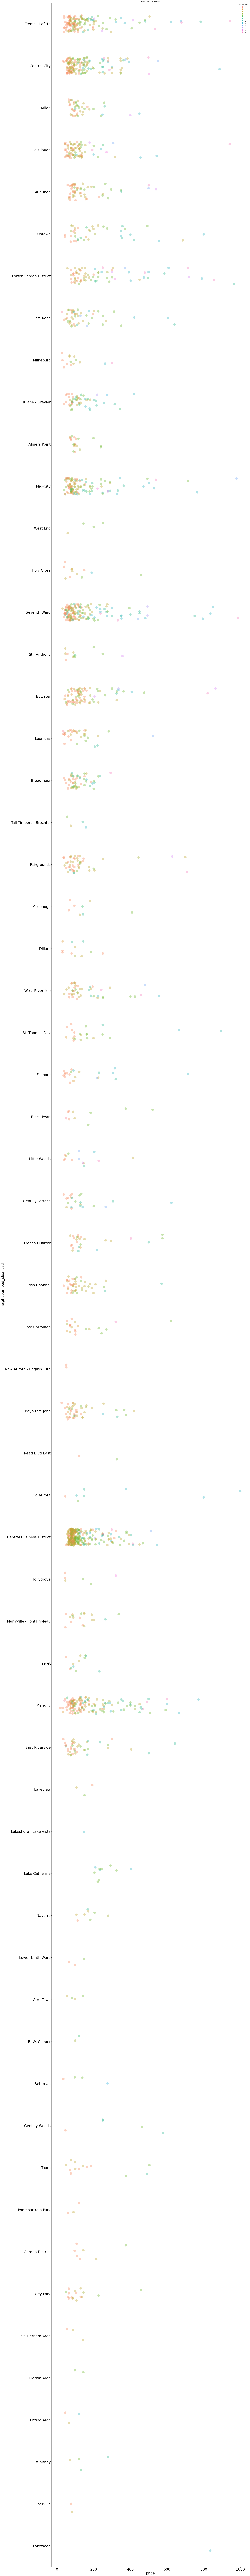

In [23]:
plt.figure(figsize = (30,400))
plt.rcParams["axes.labelsize"] = 30
plt.yticks(fontsize=30)
plt.xticks(fontsize = 30)
plt.title('Neighborhood Swarmplots')
sns.stripplot(x='price', y = "neighbourhood_cleansed", data = airbnb, hue = 'accommodates', jitter = .2, size = 20,alpha=.4)

plt.show()

In [24]:
ints = []
floats = []
for column, dtype in airbnb.dtypes.iteritems():
    if dtype == 'int64':
        ints.append(column)
    if dtype == 'float64':
        floats.append(column)

nbhd_summary = airbnb.groupby('neighbourhood_cleansed')[floats].agg('mean')
nbhd_summary = nbhd_summary.sort_values('price', ascending = False)
nbhd_summary.head()

,Median Sales Price,PercentShortTermRentals,host_response_rate,host_acceptance_rate,latitude,longitude,bathrooms_text,bedrooms,beds,price,...,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,days_active,lowest_estimate/month,middle_estimate/month,Restaurant_Count,neighborhood_restaurants,price_person
neighbourhood_cleansed,,,,,,,,,,,,,,,,,,,,,
Lakewood,543750.000000,0.000000,100.000000,100.000000,29.982310,-90.122970,4.500000,5.000000,5.000000,835.000000,...,10.000000,10.000000,10.000000,0.400000,410.000000,668.000000,1670.000000,1.000000,1.0,83.500000
Old Aurora,164500.000000,0.342394,100.000000,96.500000,29.923533,-90.004917,2.317537,3.750000,6.625000,341.875000,...,9.875000,9.625000,9.625000,1.807500,860.625000,711.413750,1477.693750,0.000000,0.0,38.463194
Gentilly Woods,126700.000000,0.454556,100.000000,94.000000,30.011148,-90.037916,2.008059,3.200000,5.200000,317.400000,...,9.800000,9.600000,9.400000,2.404000,798.000000,954.756000,2841.890000,0.000000,0.0,46.991667
Lake Catherine,140000.000000,1.543739,100.000000,98.700000,30.122045,-89.763448,2.950000,3.500000,4.900000,259.295000,...,10.000000,9.600000,9.600000,0.803000,808.600000,1303.075600,1782.198000,0.000000,0.0,38.151667
Lower Garden District,364403.296901,4.374484,96.070423,91.887324,29.934074,-90.072927,1.909018,2.580523,3.492958,251.362113,...,9.929577,9.985915,9.676056,2.071408,1176.422535,1009.412611,2474.013134,5.816901,43.0,44.629304


In [25]:
mapping = gpd.GeoDataFrame(airbnb,   geometry=airbnb.geometry.apply(wkt.loads))
#from sklearn.preprocessing import StandardScaler
#nrml = StandardScaler()
#mapping[floats] = nrml.fit_transform(mapping[floats])

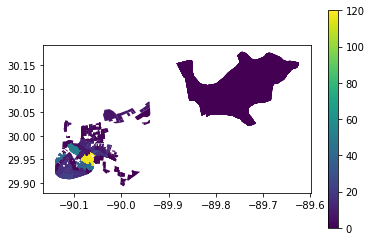

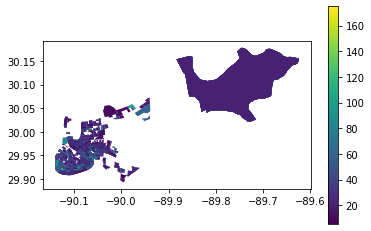

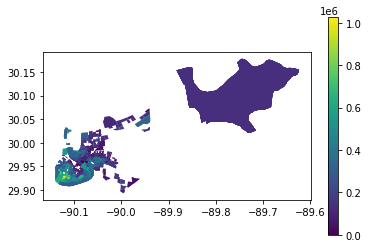

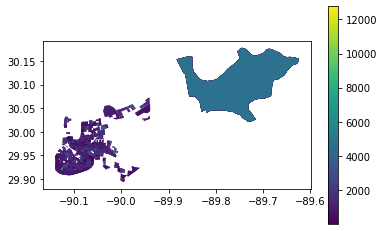

In [26]:

mapping.plot(column = 'neighborhood_restaurants',legend = True)
plt.show()
mapping.plot(column = 'price_person', legend = True)
plt.show()
mapping.plot('Median Sales Price', legend = True)
plt.show()
mapping.plot('middle_estimate/month', legend = True)
plt.show()

In [27]:
airbnb.to_csv(r'/Users/John/Desktop/Capstone_Two/data/preprocessing/airbnb.csv', index = False)

In [28]:
airbnb.head()

,the_geom,OBJECTID,geoid,Median Sales Price,PercentShortTermRentals,geometry,index_right,id,name,description,...,review_scores_value,instant_bookable,calculated_host_listings_count,reviews_per_month,days_active,lowest_estimate/month,middle_estimate/month,Restaurant_Count,neighborhood_restaurants,price_person
0,MULTIPOLYGON (((-90.08430161674 29.96889441780...,336,220710044011,134250.0,4.626335,"MULTIPOLYGON (((-90.08430 29.96889, -90.08412 ...",3012,24853908,Stayloom’s Radiant & Renovated Home | near FQ,Our home is professionally cleaned and sanitiz...,...,10.0,True,1,2.06,954.0,296.6400,1483.200,1.0,7.0,18.000000
1,MULTIPOLYGON (((-90.08430161674 29.96889441780...,336,220710044011,134250.0,4.626335,"MULTIPOLYGON (((-90.08430 29.96889, -90.08412 ...",3780,31221667,Sonder | Tremé Flats | Warm 3BR + Backyard,Whether you are just getting away for the week...,...,10.0,True,63,1.13,670.0,214.7000,536.750,1.0,7.0,15.833333
2,MULTIPOLYGON (((-90.08430161674 29.96889441780...,336,220710044011,134250.0,4.626335,"MULTIPOLYGON (((-90.08430 29.96889, -90.08412 ...",2801,24023311,"Cute, Clean, Convenient Treme/Mid-City Location!",Traditional shotgun double in fantastic Mid-Ci...,...,10.0,True,1,1.96,996.0,276.0856,690.214,1.0,7.0,17.607500
3,MULTIPOLYGON (((-90.08430161674 29.96889441780...,336,220710044011,134250.0,4.626335,"MULTIPOLYGON (((-90.08430 29.96889, -90.08412 ...",3316,27779648,Sonder | Tremé Flats | Warm 3BR,Whether you are just getting away for the week...,...,9.0,True,33,1.37,834.0,246.6000,616.500,1.0,7.0,15.000000
4,MULTIPOLYGON (((-90.08430161674 29.96889441780...,336,220710044011,134250.0,4.626335,"MULTIPOLYGON (((-90.08430 29.96889, -90.08412 ...",2787,23935301,"HISTORIC TREME, StreetCar, & Willie Mae's!",Beautiful Newly Renovated Treme Historical Sho...,...,9.0,True,1,1.65,946.0,440.5500,734.250,1.0,7.0,11.125000


array([[<AxesSubplot:title={'center':'price'}>]], dtype=object)

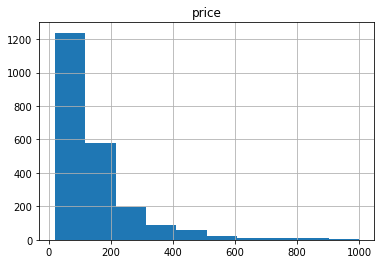

In [29]:
airbnb.hist('price')

In [32]:
print(np.mean(airbnb.price))
print(np.median(airbnb.price))
print(np.std(airbnb.price))

153.00011251125107
106.0
131.92727888630074


In [37]:
deviation = 3 * np.std(airbnb.price)

In [43]:
test = airbnb[airbnb['price']<deviation + np.median(airbnb.price)]

KeyError: "None of [Index([(12.0, 9.746794344808963, 8.392258337301111, 9.486832980505138, 9.433981132056603, 7.280109889280518, 8.602325267042627, 8.602325267042627, 12.84523257866513, 8.18535277187245, 8.06225774829855, 8.06225774829855, 8.06225774829855, 8.602325267042627, 8.577295611088614, 8.94427190999916, 10.0, 10.344080432788601, 16.0312195418814, 9.746794344808963, 7.615773105863909, 18.65475810617763, 7.416198487095663, 8.366600265340756, 7.874007874011811, 9.591663046625438, 11.180339887498949, 13.711309200802088, 8.831760866327848, 20.518284528683193, 8.831760866327848, 22.20360331117452, 10.63014581273465, 10.246950765959598, 14.966629547095765, 18.894443627691185, 13.379088160259652, 9.848857801796104, 18.841443681416774, 10.0, 9.978476837674174, 19.235384061671343, 9.273618495495704, 11.357816691600547, 9.219544457292887, 9.486832980505138, 18.708286933869708, 8.717797887081348, 9.37603327639146, 9.327379053088816, 9.433981132056603, 8.888194417315589, 10.488088481701515, 9.746794344808963, 8.06225774829855, 14.212670403551895, 7.3484692283495345, 5.477225575051661, 9.486832980505138, 6.1757590626578045, 8.237718130647588, 8.48528137423857, 9.746794344808963, 8.983874442577656, 20.518284528683193, 10.862780491200215, 11.874342087037917, 9.433981132056603, 8.660254037844387, 6.244997998398398, 12.806248474865697, 8.306623862918075, 13.152946437965905, 11.313708498984761, 12.68857754044952, 16.55294535724685, 12.449899597988733, 8.06225774829855, 10.14889156509222, 14.798648586948742, 17.728226081590904, 9.899494936611665, 8.18535277187245, 9.055385138137417, 16.0312195418814, 14.696938456699069, 11.0, 11.489125293076057, 9.055385138137417, 8.18535277187245, 18.49324200890693, 7.3484692283495345, 10.908712114635714, 10.392304845413264, 13.341664064126334, 14.560219778561036, 8.426149773176359, 12.328828005937952, 11.40175425099138, 15.459624833740307, ...)], dtype='object')] are in the [columns]"